In [1]:
import bpy
import numpy as np

import os
from typing import List, Dict
from collections import deque
import bmesh

import scipy.sparse
import scipy.linalg
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

from line_profiler import profile

from mathutils import Vector, Matrix
from mathutils.bvhtree import BVHTree

np.set_printoptions(suppress=True, linewidth=150)

# install packages : "C:\Users\Pierre.Gilibert\OneDrive - ARVERNE\Bureau\blender-4.3.1-windows-x64\4.3\python\bin\python.exe" -m pip install scipy 

In [2]:
FOLDER = "C:\\Users\\pierr\\Documents\\Blender\\GeometryProcessing_Python\\"
# FOLDER = "C:\\Users\\Pierre.Gilibert\\OneDrive - ARVERNE\\Documents\\Divers\\blender"
bpy.ops.wm.open_mainfile(filepath=os.path.join(FOLDER, "blender_notebook_v02.blend"))

{'FINISHED'}

In [3]:


class HEEdge:
    def __init__(self, edge, face, orientation:int):
        self.edge = edge
        self.face = face
        self.orientation = orientation
        self.vertex = edge.verts[orientation] # orientation in {0,1} stating whether the self.edge is in the same (0) direction as self or the opposite (1) direction.
        self.next = None
        self.twin = None
        self.angle_from_X = 0.0
        self.transport_coeff = 0.0

    def __str__(self):
        return f"HEedge : {self.edge} - orientation: {self.orientation}"
    
    def __repr__(self):
        return f"HEedge : {self.edge} - orientation: {self.orientation}"

    def __getattr__(self, item):
        # Delegate attribute access to the internal bmesh instance
        return getattr(self.edge, item)

    


In [4]:

class MYMesh:
    def __init__(self):
        self.mesh = None
        self.bm = bmesh.new()
        self.facecorners = []
        self.vert2facecorner = {}
        self.facecorner_attributes = {}             # facecorners attributes
        self.vertex_attributes = {"u":{}, "v":{}}   # u,v : basis vector of the tangent plane at each vertex
        self.edge_attributes = {}
        self.face_attributes = {}
        self.face_vertex_to_facecorner = {}
        self.co = None                              # A (|V|, 3) np array where row i contains the x,y,z coordinates of the vertex indexed by i 
        self.cotan = None                           # A (3|F|,) np array where entry i is the cotangent of the angle of facecorner (loop) i
        self.face_areas = None                      # A (|F|,) np array where entry i is the area for face i
        self.internal_angles = None                 # A (3|F|,) np array where entry i is the angle of facecorner (loop) i
        self.fv = None                              # A (|F|, 3) np array where row i contains the indices of the vertices of face i
        self.heedges = []                           # List of Half edges
        self.dict_vert2heedges = {}

    def from_mesh(self, mesh_data):
        """ Mimic the bmesh from_mesh function. """
        self.mesh = mesh_data
        self.bm.from_mesh(mesh_data)
        self.vert2facecorner = {v:[] for v in self.verts}
        self.facecorners = []
        for face in self.faces:
            self.face_vertex_to_facecorner[face] = {}
            for loop in face.loops:
                self.vert2facecorner[loop.vert].append(loop)
                self.facecorners.append(loop)
                self.face_vertex_to_facecorner[face][loop.vert] = loop
            
        self.fv = np.array([[fc.vert.index for fc in f.loops] for f in self.faces], dtype=int) # face #f has vertex [vi, vj, vk]
        self.co = np.array([v.co for v in self.verts])
        
    def to_mesh(self, mesh_data):
        """ Mimic the bmesh to_mesh function. """
        self.bm.to_mesh(mesh_data)
    
    # Add any other bmesh methods as needed:
    def free(self):
        """ Mimic the bmesh free function. """
        self.bm.free()

    # Add a custom method to directly access the internal bmesh:
    def __getattr__(self, item):
        # Delegate attribute access to the internal bmesh instance
        return getattr(self.bm, item)
    
    def ensure_lookup_tables(self):
        self.verts.ensure_lookup_table()
        self.edges.ensure_lookup_table()
        self.faces.ensure_lookup_table()

    def create_halfedge_datastructure(self):
        self.dict_vert2heedges = {}
        self.vertex_attributes["hedge"] = {}
        # self.edge_attributes["heedges"] = {}
        # for e in self.edges:
        #     self.edge_attributes["heedges"][e] = []
        for f in self.faces:
            if len(f.verts) != 3:
                raise ValueError("Not a triangular mesh : triangulate it beforehand !!")
            v_orientation = [f.verts[0].index, f.verts[1].index, f.verts[2].index]
            face_heedges = []
            for e in f.edges:
                # e0, e1, e2 = f.edges[0], f.edges[1], f.edges[2]
                v0, v1 = v_orientation.index(e.verts[0].index), v_orientation.index(e.verts[1].index)
                orientation = 1 - ((abs(v0-v1) == 1 and v0 < v1) or (abs(v0-v1) == 2 and v0 > v1)) # 0 if the edge matches the ccw convention of the face, 1 otherwise
                # print(e, v_orientation.index(e.verts[0].index), v_orientation.index(e.verts[1].index), orientation)
                face_heedges.append(HEEdge(e, f, orientation))
            he0, he1, he2 = face_heedges
            he0.next = he1
            he1.next = he2
            he2.next = he0
            self.dict_vert2heedges[(he0.vertex.index, he1.vertex.index)] = he0
            self.dict_vert2heedges[(he1.vertex.index, he2.vertex.index)] = he1
            self.dict_vert2heedges[(he2.vertex.index, he0.vertex.index)] = he2
            self.heedges.append(he0)
            self.heedges.append(he1)
            self.heedges.append(he2)
            self.vertex_attributes["hedge"][he0.vertex] = he0
            self.vertex_attributes["hedge"][he1.vertex] = he1
            self.vertex_attributes["hedge"][he2.vertex] = he2
            # self.edge_attributes["heedges"][he0.edge] = he0
            # self.edge_attributes["heedges"][he1.edge] = he1
            # self.edge_attributes["heedges"][he2.edge] = he2

        for k in self.dict_vert2heedges:
            i0, i1 = k
            if i0 < i1:
                continue
            kr = (i1, i0)
            if kr in self.dict_vert2heedges:
                self.dict_vert2heedges[k].twin = self.dict_vert2heedges[kr]
                self.dict_vert2heedges[kr].twin = self.dict_vert2heedges[k]
        
        boundary_hedges = []
        for e in self.edges:
            if not e.is_boundary:
                continue
            i0, i1 = e.verts[0].index, e.verts[1].index
            if (i0, i1) in self.dict_vert2heedges:
                existing_he = self.dict_vert2heedges[(i0, i1)]
            elif (i1, i0) in self.dict_vert2heedges:
                existing_he = self.dict_vert2heedges[(i1, i0)]
            else:
                raise ValueError(f"Unable to find an half edge between vertices {i0} and {i1}")
            new_he = HEEdge(e, None, 1-existing_he.orientation)
            existing_he.twin = new_he
            new_he.twin = existing_he
            boundary_hedges.append(new_he)
            self.dict_vert2heedges[(new_he.vertex.index, e.other_vert(new_he.vertex).index)] = new_he
            self.heedges.append(new_he)

        # match the boundary hedges
        num_link_to_create = len(boundary_hedges)
        num_link_created = 0
        while num_link_created != num_link_to_create:
            he = boundary_hedges[num_link_created]
            # other_index = -1
            for i, ohe in enumerate(boundary_hedges):
                if ohe.vertex == he.twin.vertex:
                    other_index = i
                    break
            # ohe = boundary_hedges.pop(other_index)
            he.next = ohe
            num_link_created+=1


        # verification : all hedges should have a twin and a next defined
        for k in self.dict_vert2heedges:
            he = self.dict_vert2heedges[k]
            if he.twin is None or he.next is None:
                raise ValueError(f"Unable to define a twin or a next for hedge {k} : {he}")

    def _build_d0(self):
        row = np.repeat(np.arange(len(self.edges)), 2)
        col = np.array([y for e in self.edges for y in [e.verts[0].index, e.verts[1].index]])
        val = np.ones(len(col))
        val[0::2] = -1
        # row, col, val = [], [], []
        # for e in self.edges:
        #     row.append(e.index)
        #     row.append(e.index)
        #     vi, vj = e.verts[0].index, e.verts[1].index
        #     col.append(vi)
        #     col.append(vj)
        #     if vi < vj:
        #         val.append(-1)
        #         val.append(1)
        #     else:
        #         val.append(1)
        #         val.append(-1)

        # matrix[e] = [0,0,..., 1, 0, ..., -1, ..., 0] +1 at vertex vi, -1 at vertex vj where e = [vi, vj] in that order
        return scipy.sparse.coo_matrix((val, (row, col)), shape=(len(self.edges), len(self.verts))).tocsr()

    def _build_d1(self):
        edge_dict = {tuple([e.verts[0].index, e.verts[1].index]): i for i, e in enumerate(self.edges)}
        vi, vj, vk = self.fv[:,0], self.fv[:,1], self.fv[:,2]

        row, col, val = [], [], []
        for f in self.faces:
            vi,vj,vk = self.fv[f.index]
            edges_f = [(vi,vj), (vj,vk), (vk,vi)]
            for ef in edges_f:
                row.append(f.index)

                if ef in edge_dict: # edge viewed from face matching actual edge orientation
                    col.append(edge_dict[ef])
                    val.append(1)
                else:
                    col.append(edge_dict[(ef[1], ef[0])])
                    val.append(-1)
        # face_edges = np.reshape(np.vstack((vi, vj, vj, vk, vk, vi)).T, (len(self.faces), 3, 2))
        # # face_edges[f] = [[i,j], [j,k], [k, i]] (shape 3,2) with i,j,k the vertex indices of face f and [i,j], [j,k] and [k,i] the 3 ordered edges of face f
        # sorted_face_edges = np.sort(face_edges, axis=2)
        # val = np.any(sorted_face_edges == face_edges, axis=2)*2-1 # +1 if edge in correct orientation, -1 otherwise
        # col = np.array([edge_dict[tuple(e)] for e in sorted_face_edges.reshape((-1,2))])
        # row = np.repeat(np.arange(len(self.faces)), 3)
        # matrix[f] = [0, 0,... , +-1, ..., +-1, ..., +-1, ..., 0] non 0 at ei, ej, ek where f.edges = [ei, ej, ek] and +-1 depending on whether the vertices of the ei, ej, ek are in the sorted order or not 
        return scipy.sparse.coo_matrix((val, (row, col)), shape=(len(self.faces), len(self.edges))).tocsr()

    def _build_hodge0(self, inverse=False):
        if not "area" in self.vertex_attributes:
            self._calculate_vertex_area()
        vertex_areas = self.vertex_attributes["area"]
        N = len(self.verts)
        row = np.arange(N)
        if inverse:
            return scipy.sparse.coo_matrix((1/vertex_areas, (row, row)), shape=(N, N))
        else:
            return scipy.sparse.coo_matrix((vertex_areas, (row, row)), shape=(N, N)) # dual / primal with primal = area of vertex = 1 by convention

    def _build_hodge1(self, inverse=False):
        N = len(self.edges)
        row = np.arange(N)
        val = np.zeros(N)
        for e in self.edges:
            he = self.dict_vert2heedges[(e.verts[0].index, e.verts[1].index)]
            s = 0
            for hhe in [he, he.twin]:
                if hhe.face is None:
                    # print(hhe.edge.index)
                    continue
                vk = hhe.next.next.vertex
                fck = self.face_vertex_to_facecorner[hhe.face][vk]
                s += 0.5 * self.cotan[fck.index]

            if s == 0 and inverse:
                s = 1e-9
            val[e.index] = s
            
        if inverse:
            val = 1.0/val
        return scipy.sparse.coo_matrix((val, (row, row)), shape=(N, N))
        # edge_vertex = np.array([[e.verts[0].index, e.verts[1].index] for e in self.edges])
        # edge_face_areas = np.zeros(len(self.edges))
        # for e in self.edges:
        #     s = 0
        #     for f in e.link_faces:
        #         s += self.face_areas[f.index]
        #     edge_face_areas[e.index] = s

        # edge_len = np.linalg.norm(self.co[edge_vertex[:,1]] - self.co[edge_vertex[:,0]], axis=1)
        # # dual_edge_lengths = edge_face_areas / edge_len

        # N = len(self.edges)
        # row = np.arange(N)
        # # return edge_len / edge_face_areas
        # if inverse:
        #     return scipy.sparse.coo_matrix((edge_len / edge_face_areas, (row, row)), shape=(N, N))
        # else:
        #     return scipy.sparse.coo_matrix((edge_face_areas / edge_len, (row, row)), shape=(N, N))

    def _build_hodge2(self, inverse=False):
        if not "area" in self.vertex_attributes:
            self._calculate_vertex_area()

        N = len(self.faces)
        row = np.arange(N)
        primal_areas = self.face_areas

        dual_areas = 1 #

        # fc_area = np.array([[self.facecorner_attributes["area"][self.face_vertex_to_facecorner[f][v].index] for f in self.faces for v in f.verts]]).reshape((-1,3))
        # weights = fc_area / self.face_areas[:,None]
        # vertex_area = self.vertex_attributes["area"][self.fv.ravel()].reshape((-1,3))
        # dual_areas = weights*vertex_area
        # dual_areas = dual_areas[:,0] + dual_areas[:,1] + dual_areas[:,2]
        if inverse:
            return scipy.sparse.coo_matrix((primal_areas/dual_areas, (row, row)), shape=(N, N))
        else:
            return scipy.sparse.coo_matrix((dual_areas/primal_areas, (row, row)), shape=(N, N))

    def construct_dec_operators(self, inverse_hodge0=False, inverse_hodge1=False, inverse_hodge2=False):
        """
        Constructs discrete exterior derivative operators (d0, d1) and
        Hodge star matrices (hodge0, hodge1, hodge2).
        """
        d0 = self._build_d0()
        d1 = self._build_d1()
        hodge0 = self._build_hodge0(inverse=inverse_hodge0)
        hodge1 = self._build_hodge1(inverse=inverse_hodge1)
        hodge2 = self._build_hodge2(inverse=inverse_hodge2)
        
        return d0, d1, hodge0, hodge1, hodge2

    def vector_field_to_1form(self, vector_field):
        """
        Projects a vertex-based tangent vector field onto a discrete 1-form on edges.

        Parameters:
        - vector_field: Nx3 numpy array, the tangent vector field at each vertex.

        Returns:
        - one_form: Mx1 numpy array, the discrete 1-form (edge-based representation).
        """
        
        edge_vertex = np.array([[e.verts[0].index, e.verts[1].index] for e in self.edges])
        edge_dir = self.co[edge_vertex[:,1]] - self.co[edge_vertex[:,0]]
        ui = vector_field[edge_vertex[:,0]]
        uj = vector_field[edge_vertex[:,1]]
        u_edge = 0.5 * (ui+uj)
        dot = np.einsum('ij,ij->i', u_edge, edge_dir) # fast dot product 
        return dot#/np.linalg.norm(edge_dir, axis=1)
    
    def one_form_to_vector_field(self, one_form):

        row, col, val = [], [], []
        b = 2*one_form.copy()

        n_row = 0
        for e in self.edges:
            vi, vj = e.verts[0].index, e.verts[1].index
            vec = e.verts[1].co - e.verts[0].co
            vec = vec#/np.linalg.norm(vec)
            # dot((ui + uj)/2, vec) = one_form[e77.index]
            row.extend([e.index, e.index, e.index, e.index, e.index, e.index])
            col.extend([3*vi+0, 3*vi+1, 3*vi+2, 3*vj+0, 3*vj+1, 3*vj+2])
            val.extend([vec[0], vec[1], vec[2], vec[0], vec[1], vec[2]])
            n_row+=1

        # ensure solution is in the tangent plane
        for v in self.verts:
            row.extend([n_row + v.index, n_row + v.index, n_row + v.index])
            col.extend([3*v.index + 0, 3 * v.index + 1,  3 * v.index + 2])
            n = np.array(v.normal)
            val.extend([n[0], n[1], n[2]])

        b = np.hstack((b, np.zeros(len(self.verts))))
        
        A = scipy.sparse.coo_matrix((val, (row, col))).tocsr()

        res=spsolve(A.T@A + scipy.sparse.eye(A.shape[1])*1e-9, A.T@b)
        res = res.reshape((-1,3))
        return res

    def _calculate_corner_area(self):
        if self.internal_angles is None:
            self._calculate_corner_angles_and_face_areas()

        nfaces = len(self.faces)
        ffc = np.arange(3*nfaces).reshape((nfaces, 3)) # face corner index : face #f has corners [i, j, k];
        angles = self.internal_angles[ffc] # array of alpha_i, alpha_j, alpha_k
        eij = self.co[self.fv[:,1]] - self.co[self.fv[:,0]] # edges
        ejk = self.co[self.fv[:,2]] - self.co[self.fv[:,1]]
        eki = self.co[self.fv[:,0]] - self.co[self.fv[:,2]]
        lij2 = eij[:,0]*eij[:,0] + eij[:,1]*eij[:,1] + eij[:,2]*eij[:,2] # squared lengths of the edges
        ljk2 = ejk[:,0]*ejk[:,0] + ejk[:,1]*ejk[:,1] + ejk[:,2]*ejk[:,2]
        lki2 = eki[:,0]*eki[:,0] + eki[:,1]*eki[:,1] + eki[:,2]*eki[:,2]

        # in case triangle i,j,k is non obtuse (all its angles are < pi/2) then this is the area of each face corner
        non_obtuse_area_i = 0.125 * (lij2 * self.cotan[ffc[:,2]] + lki2 * self.cotan[ffc[:,1]])
        non_obtuse_area_j = 0.125 * (ljk2 * self.cotan[ffc[:,0]] + lij2 * self.cotan[ffc[:,2]])
        non_obtuse_area_k = 0.125 * (lki2 * self.cotan[ffc[:,1]] + ljk2 * self.cotan[ffc[:,0]])

        facecorners_areas = np.zeros(3*nfaces).reshape((nfaces, 3))
        # check whether the angles are less than pi/2
        small_angle_bool = angles < np.pi/2
        big_angle_bool = ~small_angle_bool
        # True for all corners of triangle i,j,k ==> use the non_obtuse_area
        non_obtuse_bool = np.logical_and(small_angle_bool[:,0], np.logical_and(small_angle_bool[:,1], small_angle_bool[:,2]))
        facecorners_areas[non_obtuse_bool, 0] = non_obtuse_area_i[non_obtuse_bool]
        facecorners_areas[non_obtuse_bool, 1] = non_obtuse_area_j[non_obtuse_bool]
        facecorners_areas[non_obtuse_bool, 2] = non_obtuse_area_k[non_obtuse_bool]
        # False for corner p in {i,j,k}: use half the face area for p and a quarter for the two others corners
        facecorners_areas[big_angle_bool[:,0]] = self.face_areas[big_angle_bool[:,0]][:,None] * np.array([[0.5, 0.25, 0.25]])
        facecorners_areas[big_angle_bool[:,1]] = self.face_areas[big_angle_bool[:,1]][:,None] * np.array([[0.25, 0.5, 0.25]])
        facecorners_areas[big_angle_bool[:,2]] = self.face_areas[big_angle_bool[:,2]][:,None] * np.array([[0.25, 0.25, 0.5]])

        self.facecorner_attributes["area"] = facecorners_areas.ravel()

    def _calculate_corner_angles_and_face_areas(self):

        vi = self.co[self.fv[:,0]]
        vj = self.co[self.fv[:,1]]
        vk = self.co[self.fv[:,2]]

        eij, ejk, eki = vj-vi, vk-vj, vi-vk
        lij2 = eij[:,0]*eij[:,0] + eij[:,1]*eij[:,1] + eij[:,2]*eij[:,2]
        ljk2 = ejk[:,0]*ejk[:,0] + ejk[:,1]*ejk[:,1] + ejk[:,2]*ejk[:,2]
        lki2 = eki[:,0]*eki[:,0] + eki[:,1]*eki[:,1] + eki[:,2]*eki[:,2]
        lij, ljk, lki = np.sqrt(lij2), np.sqrt(ljk2), np.sqrt(lki2)

        s = 0.5 * (lij + ljk + lki) # half perimeter of every triangle
        self.face_areas = np.sqrt(s * (s - lij) * (s - ljk) * (s - lki)) # Heron's formula for the area of the triangles
        
        q_i = -ljk2 + lij2 + lki2
        q_j = -lki2 + ljk2 + lij2
        q_k = -lij2 + lki2 + ljk2

        denom_inv = 1/(4*self.face_areas)
        self.cotan = np.zeros(3*len(bm.faces))
        self.cotan[0::3] = q_i*denom_inv
        self.cotan[1::3] = q_j*denom_inv
        self.cotan[2::3] = q_k*denom_inv

        self.internal_angles = np.zeros(3*len(bm.faces))
        self.internal_angles[0::3] = np.arccos(np.clip(q_i / (2*lij * lki), -1, 1))
        self.internal_angles[1::3] = np.arccos(np.clip(q_j / (2*ljk * lij), -1, 1))
        self.internal_angles[2::3] = np.arccos(np.clip(q_k / (2*lki * ljk), -1, 1))

    def _calculate_vertex_area(self, force_recompute=False):
        # self.vertex_attributes["area"] = np.array([np.sum([self.facecorner_attributes["area"][fc.index] for fc in self.vert2facecorner[v]]) for v in self.verts])
        if not "area" in self.facecorner_attributes or force_recompute:
            self._calculate_corner_area()
            
        val = []
        for v in self.verts:
            s = 0
            for fc in self.vert2facecorner[v]:
                s += self.facecorner_attributes["area"][fc.index]
            val.append(s)
        self.vertex_attributes["area"] = np.array(val)
      
    def assign_distinguished_vector_X(self):
        all_X = []
        for v in self.verts:
            if v.is_boundary:
                boundary_edges = [e for e in v.link_edges if e.is_boundary]
                if len(boundary_edges) != 2:
                    raise ValueError(f"Non manifold mesh : vertex {v.index} does not have exactly 2 adjacent boundary edges")
                other_vs = [boundary_edges[0].other_vert(v), boundary_edges[1].other_vert(v)]
                # select the hedge starting at v and having a non None face
                vector_X = None
                for ov in other_vs:
                    key = (v.index, ov.index)
                    key_r = (ov.index, v.index)
                    for k in [key, key_r]:
                        he = self.dict_vert2heedges[k]
                        if he.vertex == v and he.face is not None:
                            vector_X = he
                            break
                    if vector_X is not None:
                        break
                if vector_X is None:
                    raise ValueError(f"Unable to find an X for boundary vertex {v.index}")
                all_X.append(vector_X)
                # if (v.index, boundary_edges[0].other_vert(v).index) in self.dict_vert2heedges:
                #     all_X.append(self.dict_vert2heedges[(v.index, boundary_edges[0].other_vert(v).index)])
                # elif (v.index, boundary_edges[1].other_vert(v).index) in self.dict_vert2heedges:
                #     all_X.append(self.dict_vert2heedges[(v.index, boundary_edges[1].other_vert(v).index)])
                # else:
                #     raise ValueError(f"Unable to find an X for boundary vertex {v.index}")
            else:
                all_X.append(self.dict_vert2heedges[(v.index, v.link_edges[0].other_vert(v).index)])
        # all_X = np.array(all_X)
        self.vertex_attributes["X"] = all_X 

    def calculate_angle_sum(self, force_recompute=False):
        if self.internal_angles is None or force_recompute:
            self._calculate_corner_angles_and_face_areas()
        angle_sum = np.zeros(len(self.verts))
        for i, v in enumerate(self.verts):
            s = 0
            for fc in self.vert2facecorner[v]:
                s += self.internal_angles[fc.index]
            angle_sum[i] = s

        self.vertex_attributes["angle_sum"] = angle_sum

    def calculate_angle_defect(self, force_recompute=False):
        if not "angle_sum" in self.vertex_attributes or force_recompute:
            self.calculate_angle_sum(force_recompute)

        boundary_coeff =  2 - np.array([v.is_boundary for v in self.verts]) # v on interior : 2 ; v on boundary : 1
        self.vertex_attributes["angle_defect"] = np.pi * boundary_coeff - self.vertex_attributes["angle_sum"]

    def calculate_gaussian_curvature(self, force_recompute=False):
        if not "area" in self.vertex_attributes or force_recompute:
            self._calculate_vertex_area(force_recompute)
        if not "angle_defect" in self.vertex_attributes or force_recompute:
            self.calculate_angle_defect(force_recompute)

        self.vertex_attributes["gaussian_curvature"] = self.vertex_attributes["angle_defect"] / self.vertex_attributes["area"]

    def compute_face_frame(self):

        vi, vj, vk = self.co[self.fv[:,0]], self.co[self.fv[:,1]], self.co[self.fv[:,2]]
        e1 = vj - vi
        e1 = e1 / np.linalg.norm(e1, axis=1)[:,None]
        e2 = vk - vi
        e2 = e2 - e1 * np.einsum('ij,ij->i',e1, e2)[:,None]
        e2 = e2/np.linalg.norm(e2, axis=1)[:,None]

        self.face_attributes["e1"] = e1
        self.face_attributes["e2"] = e2

    def shared_halfedge(self, f, g):
        vi, vj = f.verts[0].index, f.verts[1].index
        he:HEEdge
        he = self.dict_vert2heedges[(vi, vj)]
        keep_looping = True
        while keep_looping:
            if he.twin.face == g:
                return he
            he = he.next
            keep_looping = he != self.dict_vert2heedges[(vi,vj)]
        raise ValueError(f"Unable to find a common halfedge between faces {f.index} and {g.index}")
      
    def add_attribute(self, attribute_name, attribute_domain, attribute_value, is_vector):
        for attr in self.mesh.attributes:
            if attr.name.startswith(attribute_name):
                self.mesh.attributes.remove(attr)
        if is_vector:
            attr = self.mesh.attributes.new(name=attribute_name, type='FLOAT_VECTOR', domain=attribute_domain)
            attr.data.foreach_set('vector', attribute_value.flatten())
        else:
            attr = self.mesh.attributes.new(name=attribute_name, type='FLOAT', domain=attribute_domain)
            attr.data.foreach_set('value', attribute_value)



In [5]:


def draw_sphere(centre, radius, name):
    """
    Draw a sphere using Blender's bmesh module.

    Parameters:
    centre (Vector): The center of the sphere.
    radius (float): The radius of the sphere.

    Returns:
    The Blender object representing the sphere.
    """
    # Delete all objects named "Sphere" in the scene
    for obj in bpy.data.objects:
        if obj.name == name:
            bpy.data.objects.remove(obj, do_unlink=True)

    # Create a new mesh and object for the sphere
    mesh = bpy.data.meshes.new(name)
    obj = bpy.data.objects.new(name, mesh)
    # bpy.context.collection.objects.link(obj)
    # Add the object to the "Helpers" collection
    helpers_collection = ensure_helpers_collection()
    helpers_collection.objects.link(obj)

    # Create a bmesh object to define geometry
    bm = bmesh.new()
    bmesh.ops.create_uvsphere(
        bm,
        u_segments=4,
        v_segments=4,
        radius= radius
    )

    # Translate the sphere to the specified center
    bmesh.ops.translate(bm, verts=bm.verts, vec=centre)

    # Write the bmesh data to the mesh
    bm.to_mesh(mesh)
    bm.free()

    return obj

def ensure_helpers_collection():
    """
    Ensure that a collection named "Helpers" exists in the scene.
    Returns the "Helpers" collection.
    """
    if "Helpers" not in bpy.data.collections:
        helpers_collection = bpy.data.collections.new("Helpers")
        bpy.context.scene.collection.children.link(helpers_collection)
    return bpy.data.collections["Helpers"]


In [6]:
# obj = bpy.data.objects["Plane"]
# obj = bpy.data.objects["Plane.001"]
# obj = bpy.data.objects["Cube"]
# obj = bpy.data.objects["2triangles"]
# obj = bpy.data.objects["2triangles.001"]
# obj = bpy.data.objects["3triangles"]
# obj = bpy.data.objects["Triangle"]
obj = bpy.data.objects["Bunny"]

bpy.ops.object.mode_set(mode='OBJECT')
mesh = obj.data
bm = MYMesh()
bm.from_mesh(mesh)
bm.ensure_lookup_tables()
bm.create_halfedge_datastructure()
bm._calculate_corner_angles_and_face_areas()
bm.compute_face_frame()

In [ ]:
rhs = np.zeros(len(bm.verts))
rhs[0] = 1
rhs[300] = 1
rhs[6000] = 1

for obj in bpy.data.objects:
    if obj.name.startswith("sphere_"):
        bpy.data.objects.remove(obj, do_unlink=True)
for idx in np.where(rhs !=0)[0]:
    draw_sphere(bm.verts[idx].co, 0.05, f"sphere_{idx}")


h = np.mean([np.linalg.norm([e.verts[1].co - e.verts[0].co]) for e in bm.edges])
t = h*h
print(f"t = {t}")
t = 10

h0i = bm._build_hodge0(inverse=True)
h0 = bm._build_hodge0(inverse=False)
d0 = bm._build_d0()
d0T = d0.T
h1 = bm._build_hodge1()

Lc = d0T @ h1 @ d0

u = scipy.sparse.linalg.spsolve(scipy.sparse.eye(h0.shape[0]) + t*(h0i@Lc), rhs)
# u = scipy.sparse.linalg.spsolve(h0 + t*Lc, rhs)


grad = []
for f in bm.faces:
    area_f = bm.face_areas[f.index]
    vi, vj, vk = f.verts[0], f.verts[1], f.verts[2]
    ui, uj, uk = u[vi.index], u[vj.index], u[vk.index]
    eij, ejk, eki = vj.co-vi.co, vk.co-vj.co, vi.co-vk.co
    n = f.normal
    nij, njk, nki = np.cross(n, eij), np.cross(n, ejk), np.cross(n, eki)
    grad.append((1/(2*area_f)) * np.cross(n, (ui*ejk + uj*eki + uk*eij)))
    # grad.append((1/(2*area_f)) * (ui*ejk + uj*eki + uk*eij))
    # grad.append((1/(2*area_f)) * (ui*njk + uj*nki + uk*nij))

    # c = (vi.co + vj.co + vk.co)/3.0
    # source = bm.verts[np.where(rhs==1)[0][0]].co
    # grad.append(c-source)


grad = np.array(grad)
norm_grad = np.linalg.norm(grad, axis=1)
# grad[norm_grad>1e-9] = grad[norm_grad>1e-9]/norm_grad[norm_grad>1e-9][:,None]
# grad[norm_grad<=1e-9] = 0
X = grad/np.linalg.norm(grad, axis=1)[:,None]
bm.add_attribute("grad_u", "FACE", X, is_vector=True)

# integrated divergence
integrated_divergence = []
for v in bm.verts:
    he =  bm.vertex_attributes["hedge"][v]
    keep_looping = True
    res = 0
    while keep_looping:
        f = he.face
        v1, v2 = he.next.vertex, he.next.next.vertex
        fc1, fc2 = bm.face_vertex_to_facecorner[f][v1], bm.face_vertex_to_facecorner[f][v2]
        cot1, cot2 = bm.cotan[fc2.index], bm.cotan[fc1.index] # notation switch !!
        e1, e2 = v1.co - v.co, v2.co - v.co
        Xj = X[f.index]
        res += 0.5 * (cot1 * np.dot(e1, Xj) + cot2 * np.dot(e2, Xj))

        he = he.twin.next
        keep_looping = he == bm.vertex_attributes["hedge"][v]
    integrated_divergence.append(res)

integrated_divergence = np.array(integrated_divergence)

phi = scipy.sparse.linalg.spsolve(Lc+1e-9*scipy.sparse.eye(Lc.shape[0]), integrated_divergence)
print(phi)

phi = phi - phi[np.where(rhs==1)[0][0]]
# phi = phi - np.min(phi)
bm.add_attribute("phi", "POINT", np.abs(phi), is_vector=False)
phi

t = 0.0007678123100325193
[-103794.57110499 -103794.43974552 -103794.56874069 ... -103794.41439155 -103794.51387274 -103794.45135518]


array([0.        , 0.13135947, 0.00236431, ..., 0.15671344, 0.05723225, 0.11974981])

In [8]:
def face_vector_field_to_vertex_vector_field(self:MYMesh, fvf):
    vvf = []
    for v in self.verts:
        vec = np.zeros(3)
        sum_angle = 0
        for f in v.link_faces:
            fc = self.face_vertex_to_facecorner[f][v]
            vec += self.internal_angles[fc.index] * fvf[f.index]
            sum_angle+= self.internal_angles[fc.index]
        vvf.append(vec/sum_angle)
    return np.array(vvf)        

vvf = face_vector_field_to_vertex_vector_field(bm, X)
bm.add_attribute("vvf", "POINT", vvf, is_vector=True)
omega = bm.vector_field_to_1form(vvf)


h0 = bm._build_hodge0()
h0i = bm._build_hodge0(inverse=True)
h1 = bm._build_hodge1()
h1i = bm._build_hodge1(inverse=True)
h2 = bm._build_hodge2()
h2i = bm._build_hodge2(inverse=True)

d0 = bm._build_d0()
d1 = bm._build_d1()
d0T, d1T = d0.T, d1.T

# 0-form - exact component
LHS = d0T @ h1 @ d0
RHS = d0T @ h1 @ omega
alpha = scipy.sparse.linalg.spsolve(LHS, RHS)
dalpha = d0 @ alpha

# 2-form - coexact component
LHS = d1 @ h1i @ d1T
RHS = d1 @ omega
beta = scipy.sparse.linalg.spsolve(LHS, RHS)
deltabeta = h1i @ d1T @ beta

# 1-form - harmonic component
gamma = omega - dalpha - deltabeta
bm.add_attribute("vvf", "POINT", bm.one_form_to_vector_field(omega), is_vector=True)
bm.add_attribute("phi", "POINT", alpha, is_vector=False)



: 

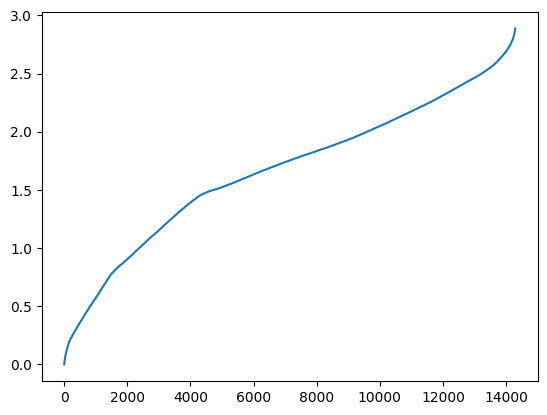

In [52]:
plt.plot(np.sort(alpha-np.min(alpha)))

In [33]:
face1form = []
for e in bm.edges:
    dir = e.verts[1].co - e.verts[0].co
    vec = np.zeros(3)
    for f in e.link_faces:
        vec += 0.5*X[f.index]
    face1form.append(np.dot(dir, vec))

bm.add_attribute("vvf", "POINT", bm.one_form_to_vector_field(np.array(face1form)), is_vector=True)


In [13]:
X.shape, len(bm.faces)

((3072, 3), 3072)

In [11]:

oneform

RuntimeError: internal error setting the array

In [144]:
omega = bm.vector_field_to_1form(-X)
delta1 =  h0i @ d0T @ h1
L0 = delta1 @ d0
phi_new = spsolve(L0, delta1 @ omega)
phi_new = phi_new - np.min(phi_new)
# phi_new = phi_new - 0.1*L0@phi_new
bm.add_attribute("phi", "POINT", phi_new, is_vector=False)
bm.add_attribute("laplacien_phi", "POINT", L0@phi_new, is_vector=False)


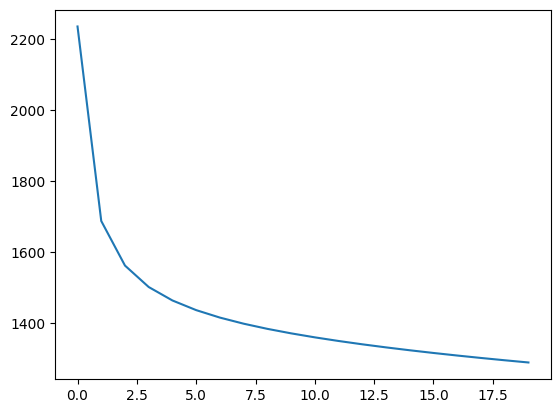

In [145]:
res = []
x = phi.copy()
# x = phi_new.copy()
min_index, max_index = np.argmin(x), np.argmax(x)
min_value, max_value = np.min(x), np.max(x)
for _ in range(20):
    L0x = L0 @ x
    energy = x.T @ L0x
    res.append(energy)
    x = x - 0.0001*L0x
    x[min_index] = min_value
    x[max_index] = max_value

bm.add_attribute("phi", "POINT", x, is_vector=False)
bm.add_attribute("laplacien_phi", "POINT", L0@x, is_vector=False)


plt.plot(res)

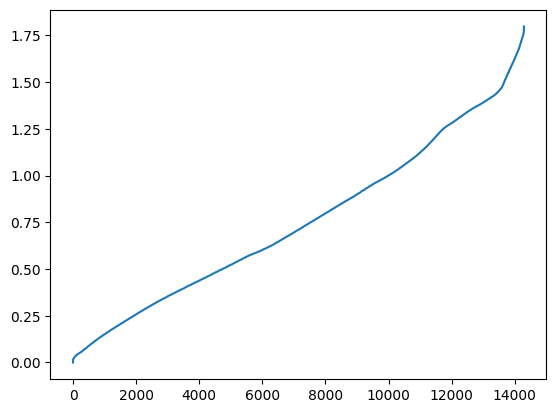

In [109]:
plt.plot(np.sort(x))

In [73]:
np.max(x)

1.520628445506763

In [42]:
# u = scipy.sparse.linalg.spsolve(scipy.sparse.eye(h0.shape[0]) + t*(h0i@Lc), rhs)

grad_phi = bm.one_form_to_vector_field(d0 @ phi)


grad = []
for f in bm.faces:
    area_f = bm.face_areas[f.index]
    vi, vj, vk = f.verts[0], f.verts[1], f.verts[2]
    ui, uj, uk = phi[vi.index], phi[vj.index], phi[vk.index]
    eij, ejk, eki = vj.co-vi.co, vk.co-vj.co, vi.co-vk.co
    n = f.normal
    nij, njk, nki = np.cross(n, eij), np.cross(n, ejk), np.cross(n, eki)
    grad.append((1/(2*area_f)) * (ui*njk + uj*nki + uk*nij))

    # c = (vi.co + vj.co + vk.co)/3.0
    # source = bm.verts[np.where(rhs==1)[0][0]].co
    # grad.append(c-source)


grad = np.array(grad)
bm.add_attribute("grad_phi", "FACE", grad, is_vector=True)




grad


array([[ 0.42333943, -0.0391627 ,  0.51669143],
       [-0.37413303, -0.20015063,  0.61340003],
       [-0.26550026,  0.40197363,  0.72049259],
       ...,
       [ 0.55388334, -0.03104887,  0.73986765],
       [ 0.56029076,  0.11697249,  0.61042917],
       [ 0.63146735, -0.02965986,  0.7003496 ]])

In [147]:
grad

array([[0.00000003, 1.        , 0.        ],
       [0.00000004, 1.        , 0.        ]])

[-1.84125550e+08 -1.84125549e+08 -1.84125550e+08 -1.84125549e+08]


array([-1.18454066,  0.        , -1.1845406 , -0.45559254])